In [1]:
import numpy as np
import pandas as pd
import os
import lightgbm as lgb
import xgboost as xgb
import time
from sklearn.kernel_ridge import KernelRidge
import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn.metrics import mean_absolute_error
from sklearn.svm import NuSVR, SVR
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
lgb_params = {
          'n_estimators':50000,
          'num_leaves': 54,
          'min_data_in_leaf': 79,
          'objective': 'huber',
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting": "gbdt",
          "bagging_freq": 5,
          "bagging_fraction": 0.8126672064208567,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1302650970728192,
          'reg_lambda': 0.3603427518866501
         }

In [23]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)

In [35]:
def createModel(X, y, X_test, cols, model = [], model_type = 'lgb', params = lgb_params, plot_feature_importance=True, ):       
    regrs = []
    oof_preds = np.zeros(len(X))
    feature_importance = pd.DataFrame()
    prediction = np.zeros(len(X_test))

    for fold_, (trn_, val_) in enumerate(folds.split(y, y)):
        y = y.ravel()
        trn_x, trn_y = X[trn_], y[trn_]
        val_x, val_y = X[val_], y[val_]
        #scaler.fit(trn_x)
        #scaler.transform(trn_x)
        #scaler.transform(val_x)
        fold_importance = pd.DataFrame()
        
        if model_type == 'lgb':
            regr = lgb.LGBMRegressor(**params)
            regr.fit(
                trn_x, trn_y,
                eval_set=[(trn_x, trn_y), (val_x, val_y)],
                eval_metric='mae',
                verbose=False,
                early_stopping_rounds = 200
            )
            oof_preds[val_] = regr.predict(val_x)
            print('fold',fold_+1,mean_absolute_error(val_y, regr.predict(val_x)))
            y_pred = regr.predict(X_test, num_iteration=regr.best_iteration_)

        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=trn_x, label=trn_y, feature_names = cols)
            valid_data = xgb.DMatrix(data=val_x, label=val_y, feature_names = cols)
            
            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            regr = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
            oof_preds[val_] = regr.predict(xgb.DMatrix(val_x, feature_names = cols), ntree_limit=regr.best_ntree_limit)
            print('fold',fold_+1,mean_absolute_error(val_y, regr.predict(xgb.DMatrix(val_x, feature_names = cols), ntree_limit=regr.best_ntree_limit)))
            y_pred = regr.predict(xgb.DMatrix(X_test, feature_names = cols), ntree_limit=regr.best_ntree_limit)

        if model_type == 'sklearn':
            regr = model
            regr.fit(trn_x, trn_y)
            
            oof_preds[val_] = regr.predict(val_x).reshape(-1,)
            print('fold',fold_+1,mean_absolute_error(val_y, regr.predict(val_x).reshape(-1,)))
            y_pred = regr.predict(X_test).reshape(-1,)
        
        if model_type == 'cat':
            regr = CatBoostRegressor(iterations=20000,  eval_metric='MAE', **params)
            regr.fit(trn_x, trn_y, eval_set=(val_x, val_y), cat_features=[], use_best_model=True, verbose=False)

            oof_preds[val_] = regr.predict(val_x)
            print('fold',fold_+1,mean_absolute_error(val_y, regr.predict(val_x)))
            y_pred = regr.predict(X_test)

        
        if model_type == 'lgb':        
            fold_importance["feature"] = cols
            fold_importance["importance"] = regr.feature_importances_
            fold_importance["fold"] = fold_ + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)


        regrs.append(regr)
        prediction += y_pred
    loss = mean_absolute_error(y, oof_preds)
    if ((model_type == 'lgb') & (plot_feature_importance == True)):
        feature_importance["importance"] /= n_fold
        cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

        best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

        plt.figure(figsize=(16, 12));
        sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
        plt.title('LGB Features (avg over folds)');
        
        return loss, regrs, feature_importance, prediction
    prediction /= n_fold
    return loss, regrs, prediction

[   0    3    4 ... 8385 8386 8387] [   1    2    5 ... 8372 8375 8380]
fold 1 2.028680655986423
[   0    1    2 ... 8380 8383 8387] [   6    8   11 ... 8384 8385 8386]
fold 2 1.9518522626122925
[   0    1    2 ... 8384 8385 8386] [   3   12   16 ... 8377 8383 8387]
fold 3 1.9916870213590347
[   0    1    2 ... 8385 8386 8387] [  13   20   24 ... 8361 8370 8378]
fold 4 1.9097347449700384
[   1    2    3 ... 8385 8386 8387] [   0    4    7 ... 8366 8367 8369]
fold 5 1.9769734758344026


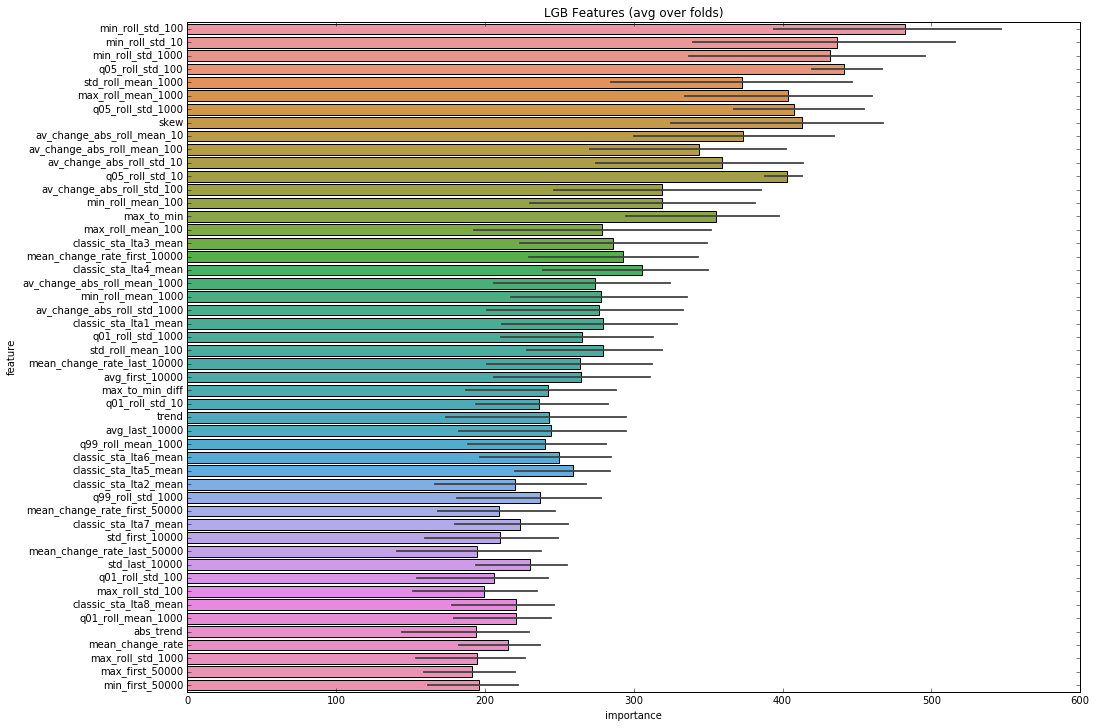

In [34]:
X_df = pd.read_csv("dataset/features.csv").drop("Unnamed: 0", axis = 1).replace([np.inf, -np.inf], np.nan)
y_df = pd.read_csv("dataset/targets.csv").drop("Unnamed: 0", axis = 1)
X_test_df = pd.read_csv("dataset/test_features.csv").drop("Unnamed: 0", axis = 1).replace([np.inf, -np.inf], np.nan)
X = X_df.fillna(X_df.mean()).values
y = y_df.fillna(y_df.mean()).values
X_test = X_test_df.fillna(X_df.mean()).values
oof_lgb, regrs, feature_importance, prediction = createModel(X, y, X_test, X_df.columns)


In [36]:
scaler = StandardScaler()
scaler.fit(X_df)
X_train_scaled = pd.DataFrame(scaler.transform(X_df), columns=X_df.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_df), columns = X_test_df.columns)
top_cols = X_df.columns

In [37]:
top_cols = list(feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index)
top_cols 

['min_roll_std_100',
 'q05_roll_std_100',
 'min_roll_std_10',
 'min_roll_std_1000',
 'skew',
 'q05_roll_std_1000',
 'max_roll_mean_1000',
 'q05_roll_std_10',
 'av_change_abs_roll_mean_10',
 'std_roll_mean_1000',
 'av_change_abs_roll_std_10',
 'max_to_min',
 'av_change_abs_roll_mean_100',
 'av_change_abs_roll_std_100',
 'min_roll_mean_100',
 'classic_sta_lta4_mean',
 'mean_change_rate_first_10000',
 'classic_sta_lta3_mean',
 'classic_sta_lta1_mean',
 'std_roll_mean_100',
 'max_roll_mean_100',
 'min_roll_mean_1000',
 'av_change_abs_roll_std_1000',
 'av_change_abs_roll_mean_1000',
 'q01_roll_std_1000',
 'avg_first_10000',
 'mean_change_rate_last_10000',
 'classic_sta_lta5_mean',
 'classic_sta_lta6_mean',
 'avg_last_10000',
 'trend',
 'max_to_min_diff',
 'q99_roll_mean_1000',
 'q99_roll_std_1000',
 'q01_roll_std_10',
 'std_last_10000',
 'classic_sta_lta7_mean',
 'classic_sta_lta8_mean',
 'q01_roll_mean_1000',
 'classic_sta_lta2_mean',
 'mean_change_rate',
 'std_first_10000',
 'mean_change_

In [39]:
X_df = X_train_scaled
X_df = X_df[top_cols]
X_test_df = X_test_scaled[top_cols]
y_df = pd.read_csv("dataset/targets.csv").drop("Unnamed: 0", axis = 1).dropna()

X = X_df.fillna(X_df.mean()).values
y = y_df.fillna(y_df.mean()).values
X_test =  X_test_df.fillna(X_df.mean()).values
oof_lgb, lgb_regrs, lgb_predictions = createModel(X, y, X_test, X_df.columns, plot_feature_importance=False)


fold 1 2.0292598398903263
fold 2 1.949235772490528
fold 3 2.002178535537505
fold 4 1.9097194296392668
fold 5 1.9794772252237343


In [10]:
lgb_predictions

array([2.41141859, 5.61197613, 6.07685136, ..., 3.59501788, 1.73599921,
       8.73528396])

In [11]:
xgb_params = {'eta': 0.03,
              'max_depth': 10,
              'subsample': 0.9,
              'objective': 'reg:linear',
              'eval_metric': 'mae',
              'silent': True,
              'nthread': 4}
oof_xgb, xgb_regrs, xgb_predictions = createModel(X, y, X_test, top_cols, params=xgb_params,  model_type='xgb')

[0]	train-mae:5.03398	valid_data-mae:5.17894
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 200 rounds.
Stopping. Best iteration:
[102]	train-mae:0.671536	valid_data-mae:2.14677

fold 1 2.1467669647675125
[0]	train-mae:5.06087	valid_data-mae:5.0738
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 200 rounds.
Stopping. Best iteration:
[101]	train-mae:0.650333	valid_data-mae:2.05251

fold 2 2.0525092920783585
[0]	train-mae:5.05365	valid_data-mae:5.09728
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 200 rounds.
Stopping. Best iteration:
[136]	train-mae:0.466587	valid_data-mae:2.15038

fold 3 2.150380766905372
[0]	train-mae:5.1006	valid_data-mae:4.90802
Multiple eval metrics have been passed: 'valid_data-mae' w

In [40]:
model = NuSVR(gamma='scale', nu=0.9, C=10.0, tol=0.01)
oof_svr1, svr1_regrs, sv1_predictions = createModel(X, y, X_test, top_cols, model, params = None,  model_type='sklearn')

fold 1 2.123534651060919
fold 2 2.060425910611998
fold 3 2.104296980927918
fold 4 2.0194084211493064
fold 5 2.0821534655247995


In [41]:
model = NuSVR(gamma='scale', nu=0.7, tol=0.01, C=1.0)
oof_svr2, svr2_regrs, sv2_predictions = createModel(X, y, X_test, top_cols, model, params = None,  model_type='sklearn')

fold 1 2.083155585921979
fold 2 2.0238855982347492
fold 3 2.0676476388600014
fold 4 1.9787311362292956
fold 5 2.054565969853448


In [42]:
model = KernelRidge(kernel='rbf', alpha=0.15, gamma=0.01)
oof_rbf, kr_regrs, kr_predictions = createModel(X, y, X_test, top_cols, model, params = None,  model_type='sklearn')

fold 1 2.091726986407239
fold 2 2.040057224051981
fold 3 2.0902082637766317
fold 4 2.002795170162773
fold 5 2.089113587750235


In [ ]:
params = {'loss_function':'MAE'}
oof_cat, cat_regs, cat_predictions = createModel(X, y, X_test, top_cols, model, params = params,  model_type='cat')

In [16]:
train_stack = np.vstack([oof_lgb, oof_xgb, oof_svr1, oof_svr2, oof_rbf, oof_cat]).transpose()
train_stack = pd.DataFrame(train_stack, columns = ['lgb', 'xgb', 'svr1', 'svr2', 'rbf', 'cat'])
test_stack = np.vstack([lgb_predictions, xgb_predictions, sv1_predictions, sv2_predictions, kr_predictions, cat_predictions]).transpose()
test_stack = pd.DataFrame(test_stack)

In [17]:
# Load submission file
submission = pd.read_csv('dataset/sample_submission.csv', index_col='seg_id', dtype={"time_to_failure": np.float32})

submission['time_to_failure'] = (lgb_predictions + xgb_predictions + sv1_predictions + sv2_predictions + cat_predictions + kr_predictions) / 6
# submission['time_to_failure'] = prediction_lgb_stack
submission.to_csv('submission.csv')

submission.head()

,time_to_failure
seg_id,
seg_00030f,2.719844
seg_0012b5,5.943235
seg_00184e,5.636822
seg_003339,8.304973
seg_0042cc,6.504095
